In [1]:
import pandas as pd
import numpy as np
import argparse
import os
import csv
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [3]:
class Analyzer(object):
    def __init__(self,root,data_path):
        self.root = root
        self.data_path = data_path

        self.data = {}

    def CheckDirectory(self,directory=None):
        if directory == None:
            directory = self.data_path
        file_list = os.listdir(directory)

        if file_list != []:
            [print(f"\tdata to read in >{file}<") for file in file_list]
            return "Success"
        else:
            return "Failed"

    def ReadData(self,file):
        try:
            os.chdir(self.data_path)
            chunksize = 100000
            tfr = pd.read_csv(file, sep=',', iterator=True, chunksize=chunksize)
            df = pd.concat(tfr, ignore_index=True)

            self.data[file] = df

            return True

        except Exception as e:

            print(f"-->Error Encountered: {e}")

            return False
    def Analyze(self,analysis_function,parameters=None):
        result_dictionary = analysis_function(self)
        
        ''' output results'''
        pd.set_option('display.max_rows', 500)
        pd.set_option('display.max_columns', 500)
        pd.set_option('display.width', 1000)

        

        return

    

In [4]:
root = "C:/Users/kdzhou/source/repos/Duo Analysis"
data_path = "/data"

In [5]:

print("-->Starting.")
print("-->Initializing Analyzer")
analyzer = Analyzer(
    root=root,
    data_path=root + data_path
)
print(f'-->Analyzer object created at {analyzer.root}, {analyzer.data_path}')




-->Starting.
-->Initializing Analyzer
-->Analyzer object created at C:/Users/kdzhou/source/repos/Duo Analysis, C:/Users/kdzhou/source/repos/Duo Analysis/data


In [6]:
print(f'-->Checking directory at {analyzer.data_path}')
file_status = analyzer.CheckDirectory()
print(f'--> File check is {file_status}')


-->Checking directory at C:/Users/kdzhou/source/repos/Duo Analysis/data
	data to read in >authentication-log-2021-03-15 - Copy.csv<
	data to read in >authentication-log-2021-03-15.csv<
	data to read in >authentication-log-2021-05-03.csv<
	data to read in >Data Analysis Results.xlsx<
	data to read in >Duo Exports<
	data to read in >Duo Exports - Copy<
	data to read in >Duo Exports.7z<
	data to read in >hawk_id_affiliation.csv<
	data to read in >phones-2021-03-22.csv<
	data to read in >phones-2021-05-03.csv<
	data to read in >Table<
	data to read in >Table.csv<
	data to read in >Table2.csv<
	data to read in >telephony-2021-03-03.csv<
	data to read in >telephony-2021-05-03.csv<
--> File check is Success


## Reading in data

In [6]:
print("-->Read Data")
if (
    analyzer.ReadData("authentication-log-2021-05-03.csv")
# and analyzer.ReadData("phones-2021-03-22.csv")
and analyzer.ReadData("hawk_id_affiliation.csv")
# and analyzer.ReadData("telephony-2021-05-03.xls")
):
    readstatus = "Success"
else:
    readstatus = "Failed"
print(f"-->Read Data is {readstatus}")

-->Read Data
-->Read Data is Success


## Without merging with affiliation type

In [7]:
if readstatus:
    afil = analyzer.data['hawk_id_affiliation.csv']
    auth = analyzer.data['authentication-log-2021-05-03.csv']
    #phones = analyzer.data['phones-2021-03-22.csv']
    #telephony = analyzer.data['telephony-2021-03-03.xls']['telephony-2021-03-03']

    '''Parse Dates into separate columns'''
    auth[["yyyymmdd","Time"]] = auth["Timestamp (UTC)"].str.split("T", expand=True)
    auth[["Year","Month","Day"]] = auth["yyyymmdd"].str.split("-", expand=True)
    auth[["Hour", "Minute", "Second","Junk"]] = auth["Time"].str.split(":", expand=True)

    auth__num_distinct_user = auth['User'].nunique()
    auth__num_distinct_country = auth['Access Device Country'].str.lower().nunique()
    auth__num_distinct_state = auth['Access Device State'].str.lower().nunique()
    auth__num_distinct_city = auth['Access Device City'].str.lower().nunique()

    auth__num_login_2020 = auth.loc[
        auth['Year'] == "2020"
    ]["Timestamp (UTC)"].count()

    auth__num_login_2021 = auth.loc[
        auth['Year'] == "2021"
        ]["Timestamp (UTC)"].count()

    auth__num_login_2020_per_month = auth.loc[
        auth['Year'] == "2020"
    ].groupby("Month")["Timestamp (UTC)"].count()

    auth__num_login_2021_per_month = auth.loc[
        auth['Year'] == "2021"
        ].groupby("Month")["Timestamp (UTC)"].count()

    auth__num_login_per_day = auth.groupby(["Month","Day"])['Timestamp (UTC)'].count().mean()

    auth__num_login_per_hour = auth.groupby(["Month", "Day", "Hour"])['Timestamp (UTC)'].count().mean()

    auth__num_login_per_minute = auth.groupby(["Month", "Day", "Hour", "Minute"])['Timestamp (UTC)'].count().mean()

    num_hours_sampled = \
    auth.groupby(["Year", "Month", "Day", "Hour"])["Timestamp (UTC)"].count().reset_index().groupby(["Hour"])[
        "Timestamp (UTC)"].count().reset_index()['Timestamp (UTC)'].mean()

    auth_average_login_through_day = auth.groupby(["Hour"])["Timestamp (UTC)"].count() / num_hours_sampled
    auth_average_login_through_day = auth_average_login_through_day.reset_index().to_csv("Table.csv",sep=",")


    auth__num_login_by_day = auth.groupby(["Year","Month","Day"])["Timestamp (UTC)"].count()

    auth__num_login_per_factor = auth.groupby(["Factor"])['Timestamp (UTC)'].count()

    auth__num_success_failures_per_factor = auth.groupby(["Factor","Result","Reason"])['Timestamp (UTC)'].count()

    auth__num_login_per_integration = auth.groupby(["Integration"])['Timestamp (UTC)'].count()

    auth__num_success_failures_login_per_integration = auth.groupby(["Integration","Factor","Result","Reason"])['Timestamp (UTC)'].count()

    auth__num_enrolled_not_enrolled = auth.groupby(["Enrollment"])['Timestamp (UTC)'].count()


    a_auth_results_dct = {
        "number of distinct users":auth__num_distinct_user,
        "number of distinct country":auth__num_distinct_country,
        "number of distinct states": auth__num_distinct_state,
        "number of distinct cities": auth__num_distinct_city,
        "number of distinct users": auth__num_distinct_user,
        "number of authentications 2020": auth__num_login_2020,
        "number of authentications 2021": auth__num_login_2021,
        "number of authentications in 2020 by month":auth__num_login_2020_per_month,
        "number of authentications in 2021 by month":auth__num_login_2021_per_month,
        "average number of authentications per day":auth__num_login_per_day,
        "average number of authentications per hour":auth__num_login_per_hour,
        "average number of authentications per minute":auth__num_login_per_minute,
        "number of authentications per factor":auth__num_login_per_factor,
        "number of authentications per integration type":auth__num_login_per_integration,
        "number of authentications by factor, result and reason":auth__num_success_failures_per_factor,
        "number of authentications by integration, factor, result and reason":auth__num_success_failures_login_per_integration,
        "number enrolled in duo":auth__num_enrolled_not_enrolled
    }

    ''' merge with database data and break down the above analysis by affiliation types '''



            

In [8]:
    "number of distinct users"
    auth__num_distinct_user

50033

In [9]:
    "number of distinct country"
    auth__num_distinct_country

80

In [10]:
    "number of distinct states"
    auth__num_distinct_state

259

In [11]:
    "number of distinct cities"
    auth__num_distinct_city

2393

In [12]:
    "number of distinct users"
    auth__num_distinct_user

50033

In [13]:
    "number of authentications 2020"
    auth__num_login_2020

506378

In [14]:
    "number of authentications in 2020 by month"
    auth__num_login_2020_per_month.reset_index()

,Month,Timestamp (UTC)
0,11,506378


In [15]:
    "average number of authentications per day"
    auth__num_login_per_day

38952.153846153844

In [16]:
    "average number of authentications per hour"
    auth__num_login_per_hour

1764.3832752613241

In [17]:
    "average number of authentications per minute"
    auth__num_login_per_minute

30.139753586096067

In [18]:
    "number of authentications per factor"
    auth__num_login_per_factor.reset_index()

,Factor,Timestamp (UTC)
0,Bypass Code,770
1,Duo Mobile Passcode,3820
2,Duo Push,105515
3,Hardware Token,158
4,Passcode,1689
5,Phone Call,102934
6,Remembered Device,245670
7,SMS Passcode,28437
8,SMS Refresh,8
9,Yubikey Passcode,218


In [19]:
    "number of authentications per integration type"
    auth__num_login_per_integration.reset_index()

,Integration,Timestamp (UTC)
0,Account Creation,156
1,CCoM ICTS REDCap Production,1744
2,College of Engineering VPN,1007
3,College of Engineering Virtual Desktop,2810
4,Employee Self Service,1042
5,HPC Users,6223
6,HPC-Systems,307
7,HawkID Login For Shibboleth,32
8,HawkID Login for ADFS,87438
9,HawkID Login for Shibboleth,2127


In [20]:
    "number of authentications by factor, result and reason"
    auth__num_success_failures_per_factor.reset_index()

,Factor,Result,Reason,Timestamp (UTC)
0,Bypass Code,FAILURE,Invalid passcode,119
1,Bypass Code,SUCCESS,Valid passcode,651
2,Duo Mobile Passcode,FAILURE,Invalid passcode,63
3,Duo Mobile Passcode,SUCCESS,Valid passcode,3757
4,Duo Push,FAILURE,Invalid device,131
5,Duo Push,FAILURE,No response,3440
6,Duo Push,FAILURE,User mistake,71
7,Duo Push,FRAUD,User marked fraud,6
8,Duo Push,SUCCESS,User approved,101867
9,Hardware Token,SUCCESS,Valid passcode,158


In [21]:
    "number of authentications by integration, factor, result and reason"
    auth__num_success_failures_login_per_integration.reset_index()

,Integration,Factor,Result,Reason,Timestamp (UTC)
0,Account Creation,Duo Mobile Passcode,SUCCESS,Valid passcode,10
1,Account Creation,Duo Push,FAILURE,No response,3
2,Account Creation,Duo Push,SUCCESS,User approved,43
3,Account Creation,Passcode,FAILURE,Invalid passcode,3
4,Account Creation,Phone Call,FAILURE,No keys pressed,1
5,Account Creation,Phone Call,SUCCESS,User approved,19
6,Account Creation,SMS Passcode,SUCCESS,Valid passcode,3
7,CCoM ICTS REDCap Production,Duo Mobile Passcode,SUCCESS,Valid passcode,8
8,CCoM ICTS REDCap Production,Duo Push,FAILURE,No response,31
9,CCoM ICTS REDCap Production,Duo Push,FAILURE,User mistake,1


In [22]:
    "number enrolled in duo"
    auth__num_enrolled_not_enrolled.reset_index()

,Enrollment,Timestamp (UTC)
0,False,506291
1,True,87


## Merging with affiliation data

In [23]:

    
    '''Identify data pieces'''
    afil = analyzer.data['hawk_id_affiliation.csv']
    afil.columns = ['HawkId','edupersonaffiliation','edupersonprimaryaffiliation']
    
    auth = analyzer.data['authentication-log-2021-05-03.csv']
    
    '''Parse Dates into separate columns'''
    
    auth[["yyyymmdd","Time"]] = auth["Timestamp (UTC)"].str.split("T", expand=True)
    auth[["Year","Month","Day"]] = auth["yyyymmdd"].str.split("-", expand=True)
    auth[["Hour", "Minute", "Second","Junk"]] = auth["Time"].str.split(":", expand=True)
    
    auth_afil = pd.merge(
        left=auth,
        left_on="User",
        right=afil,
        right_on="HawkId",
        how="left"
    )


In [24]:
    '''Number of authentications per kind of affilliation'''
    auth_afil_num_per_type = auth_afil.groupby("edupersonprimaryaffiliation")["Timestamp (UTC)"].count().reset_index()
    auth_afil_num_per_type

,edupersonprimaryaffiliation,Timestamp (UTC)
0,affiliate,884
1,faculty,49155
2,member,823
3,staff,150192
4,student,267649


In [25]:
    '''Average number of authentications per affilliation per day'''
    
    auth_afil_num_auth_per_day_by_affil = \
        auth_afil.groupby(["Day","edupersonprimaryaffiliation"])['Timestamp (UTC)'].count()\
                 .groupby(["edupersonprimaryaffiliation"])
    
    auth_afil_num_auth_per_day_by_affil_mean = auth_afil_num_auth_per_day_by_affil.mean().reset_index()
    
    #auth_afil_number_auth_per_day_by_affiliation = \
        #auth_afil.groupby(["Day","edupersonprimaryaffiliation"])['Timestamp (UTC)'].count()
        
    auth_afil_num_auth_per_day_by_affil_mean
    
    #print(f"{auth_afil_number_auth_per_day_by_affiliation}\n")

,edupersonprimaryaffiliation,Timestamp (UTC)
0,affiliate,68.000000
1,faculty,3781.153846
2,member,63.307692
3,staff,11553.230769
4,student,20588.384615


In [26]:
    '''Standard Deviation'''
    auth_afil_num_auth_per_day_by_affil_std = auth_afil_num_auth_per_day_by_affil.std().reset_index()
    auth_afil_num_auth_per_day_by_affil_std

,edupersonprimaryaffiliation,Timestamp (UTC)
0,affiliate,25.784362
1,faculty,1628.629631
2,member,26.014049
3,staff,6679.295811
4,student,7222.243944


In [27]:
    ''' Number of authentications by hour broken down by affiliation type'''
    auth_afil_num_auth_per_single_hr_by_affil = \
        auth_afil.groupby(["Hour","edupersonprimaryaffiliation"])['Timestamp (UTC)'].count()\
                 .groupby(["edupersonprimaryaffiliation"])
        
    auth_afil_num_auth_per_single_hr_by_afil_mean = auth_afil_num_auth_per_single_hr_by_affil.mean().reset_index()
    
    
    auth_afil_num_auth_per_single_hr_by_afil_mean
    


,edupersonprimaryaffiliation,Timestamp (UTC)
0,affiliate,38.434783
1,faculty,2048.125000
2,member,34.291667
3,staff,6258.000000
4,student,11152.041667


In [28]:
    '''Standard deviation'''
    auth_afil_num_auth_per_single_hr_by_affil_std = auth_afil_num_auth_per_single_hr_by_affil.std().reset_index()
    auth_afil_num_auth_per_single_hr_by_affil_std

,edupersonprimaryaffiliation,Timestamp (UTC)
0,affiliate,26.706870
1,faculty,1603.208205
2,member,23.999056
3,staff,5776.774480
4,student,7617.840710


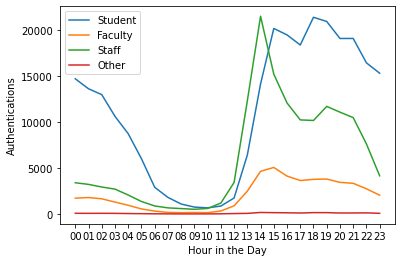

In [29]:
    '''Number of Authentications throughout the day by affilliation type'''
    
    auth_afil_num_auth_per_hr_by_affil = auth_afil.groupby(["Hour","edupersonprimaryaffiliation"])['Timestamp (UTC)'].count().reset_index()
    
    student = auth_afil_num_auth_per_hr_by_affil.loc[
        (auth_afil_num_auth_per_hr_by_affil["edupersonprimaryaffiliation"] == "student")
    ]
    faculty = auth_afil_num_auth_per_hr_by_affil.loc[
        (auth_afil_num_auth_per_hr_by_affil["edupersonprimaryaffiliation"] == "faculty")
    ]
    staff = auth_afil_num_auth_per_hr_by_affil.loc[
        (auth_afil_num_auth_per_hr_by_affil["edupersonprimaryaffiliation"] == "staff")
    ]
    other = auth_afil_num_auth_per_hr_by_affil.loc[
        ~(auth_afil_num_auth_per_hr_by_affil["edupersonprimaryaffiliation"].isin(["student","faculty","staff"]))
    ].groupby('Hour')["Timestamp (UTC)"].sum().reset_index()
    
    
    fig, ax = plt.subplots()
    
    ax.plot(student["Hour"],student["Timestamp (UTC)"],label="Student")
    ax.plot(student["Hour"],faculty["Timestamp (UTC)"],label="Faculty")
    ax.plot(student["Hour"],staff["Timestamp (UTC)"],label="Staff")
    ax.plot(student["Hour"],other["Timestamp (UTC)"],label="Other")
    
    ax.set_xlabel("Hour in the Day")
    ax.set_ylabel("Authentications")
    ax.legend()


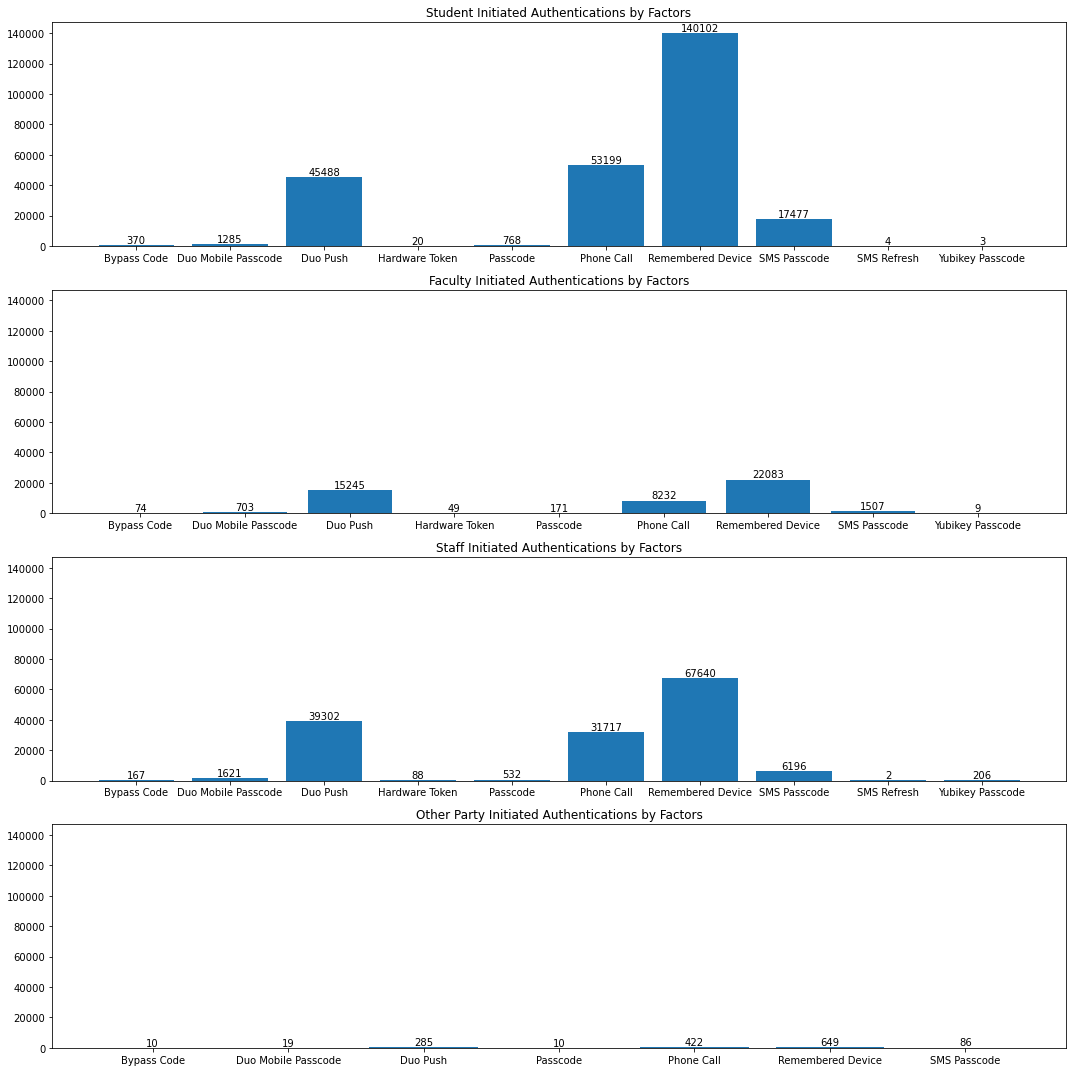

In [30]:
    '''Number of Authentications by Factor and Affilliation'''
    
    ## group by factor and affiliation and count num authentications
    auth_afil__factor_by_afil = auth_afil.groupby(["Factor","edupersonprimaryaffiliation"])['Timestamp (UTC)'].count().reset_index()
    
    ## make figure with 4 axes (one for each graph), sharing y axis and a set size
    fig, (student_ax, faculty_ax,staff_ax, other_ax) = plt.subplots(4,sharey=True,figsize=(15,15))
    
    ## graph student data
    student = auth_afil__factor_by_afil.loc[
        (auth_afil__factor_by_afil["edupersonprimaryaffiliation"] == "student")
    ][['Factor','Timestamp (UTC)']]
    
    student_x_axis = student['Factor']
    student_y_axis = student['Timestamp (UTC)']
    student_ax.bar(student_x_axis,student_y_axis)
    student_ax.set_title("Student Initiated Authentications by Factors")

    rects = student_ax.patches
    labels = [str(y) for y in student_y_axis]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        student_ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
                ha='center', va='bottom')
    
    
    ## graph faculty data
    faculty = auth_afil__factor_by_afil.loc[
        (auth_afil__factor_by_afil["edupersonprimaryaffiliation"] == "faculty")
    ][['Factor','Timestamp (UTC)']]
   
    faculty_x_axis = faculty['Factor']
    faculty_y_axis = faculty['Timestamp (UTC)']
    faculty_ax.bar(faculty_x_axis,faculty_y_axis)
    faculty_ax.set_title("Faculty Initiated Authentications by Factors")

    rects = faculty_ax.patches
    labels = [str(y) for y in faculty_y_axis]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        faculty_ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
                ha='center', va='bottom')
        
    ## graph staff data
    
    staff = auth_afil__factor_by_afil.loc[
        (auth_afil__factor_by_afil["edupersonprimaryaffiliation"] == "staff")
    ][['Factor','Timestamp (UTC)']]
    
    staff_x_axis = staff['Factor']
    staff_y_axis = staff['Timestamp (UTC)']
    staff_ax.bar(staff_x_axis,staff_y_axis)
    staff_ax.set_title("Staff Initiated Authentications by Factors")
    
    rects = staff_ax.patches
    labels = [str(y) for y in staff_y_axis]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        staff_ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
                ha='center', va='bottom')
    
    
    
    # print(f'{student}\n')    
    other = auth_afil__factor_by_afil.loc[
        (~auth_afil__factor_by_afil["edupersonprimaryaffiliation"].isin(["student","faculty","staff"]))
    ].groupby('Factor')['Timestamp (UTC)'].sum().reset_index()
    
    other_x_axis = other['Factor']
    other_y_axis = other['Timestamp (UTC)']
    other_ax.bar(other_x_axis,other_y_axis)
    other_ax.set_title("Other Party Initiated Authentications by Factors")
    
    rects = other_ax.patches
    labels = [str(y) for y in other_y_axis]
    
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        other_ax.text(rect.get_x() + rect.get_width() / 2, height + 5, label,
                ha='center', va='bottom')
    

    fig.tight_layout()
    


In [39]:
    student = auth_afil__factor_by_afil.loc[
        (auth_afil__factor_by_afil["edupersonprimaryaffiliation"] == "student")
    ][['Factor','Timestamp (UTC)']]
    
    auth_afil.loc[
        (auth_afil["edupersonprimaryaffiliation"] == "student")
        &
        (auth_afil["Factor"] == "Yubikey Passcode")
    ]
    
#     student_x_axis = student['Factor']
#     student_y_axis = student['Timestamp (UTC)']
#     student_ax.bar(student_x_axis,student_y_axis)
#     student_ax.set_title("Student Initiated Authentications by Factors")

,Timestamp (UTC),User,Integration,Factor,Result,Reason,Enrollment,2FA Device Name,2FA Device IP,2FA Device Country,2FA Device State,2FA Device City,Access Device IP,Access Device Country,Access Device State,Access Device City,Access Device Hostname,Alias,Email,Out Of Date Software,yyyymmdd,Time,Year,Month,Day,Hour,Minute,Second,Junk,HawkId,edupersonaffiliation,edupersonprimaryaffiliation
239921,2020-11-10T15:06:50.507211+00:00,zmiller1,Web Login (login.uiowa.edu),Yubikey Passcode,FAILURE,Invalid passcode,False,NaN,NaN,NaN,NaN,NaN,205.175.226.96,US,Iowa,Cedar Rapids,NaN,NaN,zachary-r-miller@uiowa.edu,NaN,2020-11-10,15:06:50.507211+00:00,2020,11,10,15,06,50.507211+00,00,zmiller1,"member,student",student
362888,2020-11-12T18:13:29.743100+00:00,tholubar,Web Login (login.uiowa.edu),Yubikey Passcode,FAILURE,Invalid passcode,False,NaN,NaN,NaN,NaN,NaN,205.175.226.96,US,Iowa,Cedar Rapids,NaN,NaN,thomas-holubar@uiowa.edu,NaN,2020-11-12,18:13:29.743100+00:00,2020,11,12,18,13,29.743100+00,00,tholubar,"member,student",student
444831,2020-11-14T18:01:52.473621+00:00,zmiller1,Web Login (login.uiowa.edu),Yubikey Passcode,FAILURE,Invalid passcode,False,NaN,NaN,NaN,NaN,NaN,157.52.61.207,US,Iowa,Central City,NaN,NaN,zachary-r-miller@uiowa.edu,NaN,2020-11-14,18:01:52.473621+00:00,2020,11,14,18,01,52.473621+00,00,zmiller1,"member,student",student


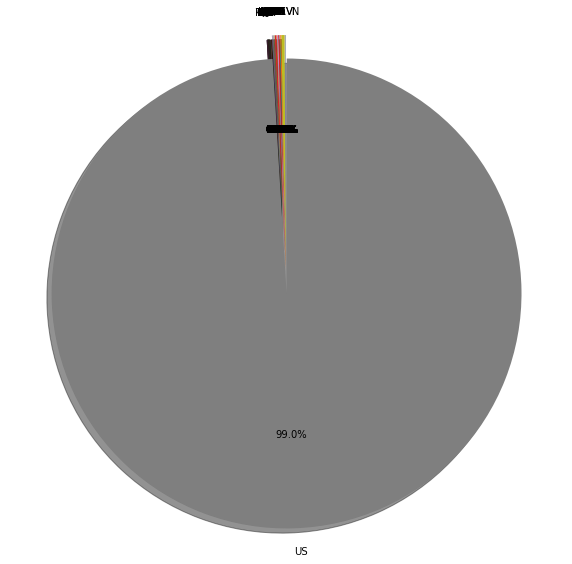

In [35]:
    '''Number of Authentications by Nation'''
    
    auth_by_nation = auth.groupby('Access Device Country')['Timestamp (UTC)'].count().reset_index()
    
    labels = auth_by_nation['Access Device Country']
    sizes = auth_by_nation['Timestamp (UTC)']
    
    fig, ax1 = plt.subplots(figsize=(10,10))
    
    explode = [0 for x in range(0,len(labels))]
    explode[77] = 0.1
    
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
    
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()
    
    
    

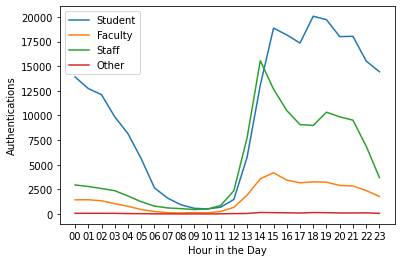

In [33]:
    ''' US ONLY average num auth throughout day '''

    auth_afil_us = auth_afil.loc[
        (auth['Access Device Country'].str.upper() == 'US')
    ]

    auth_afil_num_auth_per_hr_by_affil = auth_afil_us.groupby(["Hour","edupersonprimaryaffiliation"])['Timestamp (UTC)'].count().reset_index()
    
    student = auth_afil_num_auth_per_hr_by_affil.loc[
        (auth_afil_num_auth_per_hr_by_affil["edupersonprimaryaffiliation"] == "student")
    ]
    faculty = auth_afil_num_auth_per_hr_by_affil.loc[
        (auth_afil_num_auth_per_hr_by_affil["edupersonprimaryaffiliation"] == "faculty")
    ]
    staff = auth_afil_num_auth_per_hr_by_affil.loc[
        (auth_afil_num_auth_per_hr_by_affil["edupersonprimaryaffiliation"] == "staff")
    ]
    other = auth_afil_num_auth_per_hr_by_affil.loc[
        ~(auth_afil_num_auth_per_hr_by_affil["edupersonprimaryaffiliation"].isin(["student","faculty","staff"]))
    ].groupby('Hour')["Timestamp (UTC)"].sum().reset_index()
    
    
    fig, ax = plt.subplots()
    
    ax.plot(student["Hour"],student["Timestamp (UTC)"],label="Student")
    ax.plot(student["Hour"],faculty["Timestamp (UTC)"],label="Faculty")
    ax.plot(student["Hour"],staff["Timestamp (UTC)"],label="Staff")
    ax.plot(student["Hour"],other["Timestamp (UTC)"],label="Other")
    
    ax.set_xlabel("Hour in the Day")
    ax.set_ylabel("Authentications")
    ax.legend()


In [34]:
    '''Authentication by Integration, Factor, Success, and Reason'''
    pd.set_option('display.max_columns',None)
    pd.set_option('display.max_rows',None)
    auth_afil__num_scs_fail_per_factor = auth_afil.groupby(["Integration",
                                                            "Factor",
                                                            "Result",
                                                            "Reason",
                                                            "edupersonprimaryaffiliation"])['Timestamp (UTC)'].count().reset_index()
    
    auth_afil__num_scs_fail_per_factor

,Integration,Factor,Result,Reason,edupersonprimaryaffiliation,Timestamp (UTC)
0,Account Creation,Duo Mobile Passcode,SUCCESS,Valid passcode,staff,9
1,Account Creation,Duo Push,FAILURE,No response,staff,3
2,Account Creation,Duo Push,SUCCESS,User approved,staff,35
3,Account Creation,Duo Push,SUCCESS,User approved,student,2
4,Account Creation,Passcode,FAILURE,Invalid passcode,staff,3
5,Account Creation,Phone Call,FAILURE,No keys pressed,staff,1
6,Account Creation,Phone Call,SUCCESS,User approved,staff,15
7,Account Creation,Phone Call,SUCCESS,User approved,student,1
8,Account Creation,SMS Passcode,SUCCESS,Valid passcode,staff,2
9,CCoM ICTS REDCap Production,Duo Mobile Passcode,SUCCESS,Valid passcode,affiliate,1
